# STL10 DataSet for Fellowship.AI 

Directory structure:
```
lesson1/
    data/
        stl10.ipynb
        
        stl10/
        
            binary/
                train_X.bin
                train_y.bin
                
                test_X.bin
                test_y.bin
                
                unlabeled_X.bin
                
                class_names.txt
                fold_indices.txt
                        
```

In [1]:
#Check the dirctory 
%cd ~/Anaconda3/lesson1
%pwd

C:\Users\saurabh\Anaconda3\lesson1


'C:\\Users\\saurabh\\Anaconda3\\lesson1'

In [2]:
#Create references to important directories we will use over and over
import os, sys
current_dir = os.getcwd()
LESSON_HOME_DIR = current_dir
DATA_HOME_DIR = current_dir+'\\data\\stl10\\'
DATA_BIN_DIR = current_dir+'\\data\\stl10\\binary\\'
DATA_TRAIN_DIR = current_dir+'\\data\\stl10\\train\\'
DATA_IMG_DIR = current_dir+'\\data\\stl10\\images\\'
DATA_VAL_DIR = current_dir+'\\data\\stl10\\valid\\'
print("LESSON_HOME_DIR is : " + str(LESSON_HOME_DIR))
print("DATA_HOME_DIR is : " + str(DATA_HOME_DIR))

LESSON_HOME_DIR is : C:\Users\saurabh\Anaconda3\lesson1
DATA_HOME_DIR is : C:\Users\saurabh\Anaconda3\lesson1\data\stl10\


In [3]:
%matplotlib inline

#if using Theano with GPU
#os.environ["THEANO_FLAGS"] = "mode=FAST_RUN,device=gpu,floatX=float32"

import random
import numpy as np
import keras

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import PIL

from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Model

Using Theano backend.


In [4]:
# %load '~/utils/input.py'
#Adapted from the python code at https://cs.stanford.edu/~acoates/stl10/
from __future__ import print_function

import sys
import os, sys, tarfile
import numpy as np
import matplotlib.pyplot as plt
#from keras.preprocessing import image

#For copying/moving files into appropriate dircetories
from shutil import copyfile
#https://stackoverflow.com/questions/35613249/using-ipdb-to-debug-python-code-in-one-cell-jupyter-or-ipython
from IPython.core.debugger import set_trace
    
if sys.version_info >= (3, 0, 0):
    import urllib.request as urllib # ugly but works
else:
    import urllib

print(sys.version_info) 

# image shape
HEIGHT = 96
WIDTH = 96
DEPTH = 3

#Making output stable across runs
np.random.seed(42)

# size of a single image in bytes
SIZE = HEIGHT * WIDTH * DEPTH

# path to the directory with the data
DATA_HOME_BIN_DIR = DATA_HOME_DIR+'\\'

# url of the binary data
# DATA_URL = 'http://ai.stanford.edu/~acoates/stl10/stl10_binary.tar.gz'

#Train
# path to the binary train file with image data
DATA_PATH = DATA_BIN_DIR+'train_X.bin'
# path to the binary train file with labels
LABEL_PATH = DATA_BIN_DIR+'train_y.bin'

#Test
# path to the binary test file with image data
DATA_TEST_PATH = DATA_BIN_DIR+'test_X.bin'
# path to the binary test file with labels
LABEL_TEST_PATH = DATA_BIN_DIR+'test_y.bin'

#Unlabeled Data
UNLABELED_PATH = DATA_BIN_DIR+'unlabeled_X.bin'

#Fold Path - ie the path for Fold Indices
FOLD_PATH = DATA_BIN_DIR+'fold_indices.txt'

def read_labels(path_to_labels):
    """
    :param path_to_labels: path to the binary file containing labels from the STL-10 dataset
    :return: an array containing the labels
    """
    with open(path_to_labels, 'rb') as f:
        labels = np.fromfile(f, dtype=np.uint8)
        return labels

def read_indices(path_to_indices):
    """
    :param path_to_indices: path to the Text file containing indices from the STL-10 dataset
    :return: an array containing the indices
    """
    #Separator = space signifies that this is a text file
    with open(path_to_indices, 'rb') as f:
        indices = np.fromfile(f, dtype=np.int, sep=' ')
        return indices
    

def read_all_images(path_to_data, flag_for_moving=0):
    """
    :param path_to_data: the file containing the binary images from the STL-10 dataset
    :return: an array containing all the images
    """

    with open(path_to_data, 'rb') as f:
        # read whole file in uint8 chunks
        everything = np.fromfile(f, dtype=np.uint8)

        # We force the data into 3x96x96 chunks, since the
        # images are stored in "column-major order", meaning
        # that "the first 96*96 values are the red channel,
        # the next 96*96 are green, and the last are blue."
        # The -1 is since the size of the pictures depends
        # on the input file, and this way numpy determines
        # the size on its own.

        images = np.reshape(everything, (-1, 3, 96, 96))

        # Now transpose the images into a standard image format
        # readable by, for example, matplotlib.imshow
        # You might want to comment this line or reverse the shuffle
        # if you will use a learning algorithm like CNN, since they like
        # their channels separated.
        images = np.transpose(images, (0, 3, 2, 1))
        return images


def read_single_image(image_file):
    """
    CAREFUL! - this method uses a file as input instead of the path - so the
    position of the reader will be remembered outside of context of this method.
    :param image_file: the open file containing the images
    :return: a single image
    """
    # read a single image, count determines the number of uint8's to read
    image = np.fromfile(image_file, dtype=np.uint8, count=SIZE)
    # force into image matrix
    image = np.reshape(image, (3, 96, 96))
    # transpose to standard format
    # You might want to comment this line or reverse the shuffle
    # if you will use a learning algorithm like CNN, since they like
    # their channels separated.
    image = np.transpose(image, (2, 1, 0))
    return image


def plot_image(image):
    """
    :param image: the image to be plotted in a 3-D matrix format
    :return: None
    """
    plt.imshow(image)
    plt.show()

def save_fig(fig_id):
    path = os.path.join(DATA_TRAIN_DIR, "images", str(fig_id) + ".png")
    #print("Saving figure", fig_id)
    #plt.savefig(path, format='png', dpi=300)
    plt.tight_layout()
    plt.savefig(path, format='png')
    
#Allocate into X_train and X_test
X_train = read_all_images(DATA_PATH,1)
X_test  = read_all_images(DATA_TEST_PATH)
#    print(images.shape)

#Allocate into y_train and y_test
y_train = read_labels(LABEL_PATH)
y_test  = read_labels(LABEL_TEST_PATH)
#    print(labels.shape)

#0 airplane #1 bird #2 car #3 cat #4 deer #5 dog #6 horse #7 monkey #8 ship #9 truck
y_train = y_train - 1
y_test  = y_test - 1

num_classes = 10

# Shuffle the Training Data Set now
# We have 5000 Training Images
shuffle_index = np.random.permutation(5000)
print("Len of Shuffle Index", len(shuffle_index))
All_X_train, All_y_train = X_train[shuffle_index], y_train[shuffle_index]

#Create Train, Validation and Test Splits 
train_split, val_split = 0.7, 0.15

idx_val = int(train_split * len(shuffle_index))
print("Len of Shuffle Index", len(shuffle_index))
print("Index of Val Start", idx_val)

idx_test = int((train_split + val_split) * len(shuffle_index))
print("Idx Test is :",idx_test)
X_train, y_train = All_X_train[:idx_val], All_y_train[:idx_val] #70% of Total Data
X_val, y_val     = All_X_train[idx_val:idx_test], All_y_train[idx_val:idx_test] #15% 


#Read Indices
fold_indices = read_indices(FOLD_PATH)
fold_indices = fold_indices.reshape(10,1000)

#Reading unlabeled dataset
X_unlabeled_all = read_all_images(UNLABELED_PATH)

print("Shape of X Unlabeled", X_unlabeled_all.shape)



sys.version_info(major=3, minor=6, micro=3, releaselevel='final', serial=0)
Len of Shuffle Index 5000
Len of Shuffle Index 5000
Index of Val Start 3500
Idx Test is : 4250
Shape of X Unlabeled (100000, 96, 96, 3)


Checking for 1st 1000 Unlabeled Images  (1000, 96, 96, 3)


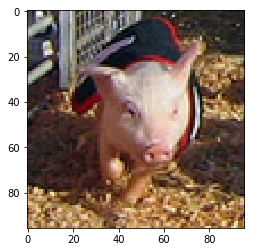

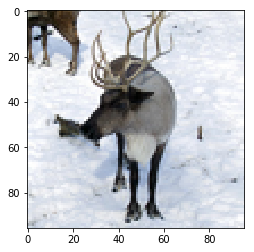

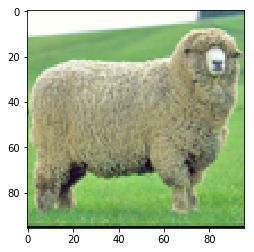

Shape of Image  2 (96, 96, 3)
Number of Dimensions  2 3
X  2 [[[254 255 249]
  [254 255 249]
  [254 255 249]
  ..., 
  [ 70 105 127]
  [ 72 103 133]
  [ 72 104 132]]

 [[254 255 249]
  [254 255 249]
  [254 255 249]
  ..., 
  [ 87 132 133]
  [ 89 137 132]
  [ 92 147 134]]

 [[254 255 249]
  [254 255 249]
  [254 255 249]
  ..., 
  [126 185 139]
  [125 189 138]
  [131 190 135]]

 ..., 
 [[102 164  89]
  [110 178  88]
  [ 99 170  93]
  ..., 
  [127 178 108]
  [123 187 100]
  [111 178  91]]

 [[ 95 146  80]
  [ 91 154  69]
  [ 92 156  79]
  ..., 
  [100 149  77]
  [ 94 150  72]
  [105 164  84]]

 [[  6   8   5]
  [  5   8   4]
  [  5   8   4]
  ..., 
  [  6   8   5]
  [  3   5   1]
  [  5   8   5]]]


In [5]:
#Take 1000 examples from the unlabeled dataset
X_unlabeled_1K = []
X_unlabeled_1K = X_unlabeled_all[5000:6000]
print("Checking for 1st 1000 Unlabeled Images ", X_unlabeled_1K.shape)
for i in range(3):
    plot_image(X_unlabeled_1K[i])
print("Shape of Image ", str(i), X_unlabeled_1K[i].shape)    
print("Number of Dimensions ", str(i), X_unlabeled_1K[i].ndim)
print("X ", str(i), X_unlabeled_1K[i])
save_fig(i)

In [6]:
# Comment out this line when done with some basic testing
# Just using part of Training Data first, will switch to given data later
X_test, y_test   = All_X_train[idx_test:], All_y_train[idx_test:] #Remaining data (ie 15%)


In [7]:
#Checking the Training Images in each fold

# fold_indices = fold_indices.reshape(10,1000)

# # for i in range(10):

# #Random check for 2d row - each row is from 0 to 999?
# i =999
# print("Fold indices ", fold_indices[1][0])
# plot_image(X_train[fold_indices[1][0]])
# print("Shape of X train",X_train.shape)
# print("Shape of y train",y_train.shape)
# print(y_train_new[fold_indices[1][0]])
# print("\n")

#0 airplane #1 bird #2 car #3 cat #4 deer #5 dog #6 horse #7 monkey #8 ship #9 truck

#     plot_image(X_train[fold_indices[i][0]])
# 
# for i in range(8):
#     print("Length of "+str(i)+" fold : ", len(X_train[fold_indices[i]]))

In [8]:
# normalize data
X_train = X_train.astype('float32') / 255.
X_val = X_val.astype('float32') / 255.
X_test = X_test.astype('float32') / 255.

In [9]:
#Printing X Train, X Val and X Test
print("X Train : " ,X_train[0][95])
print("\n")
print("X Val : " ,X_val[0][95])
print("\n")
print("X Test : " ,X_test[0][95])
print("\n")



X Train :  [[ 0.56078434  0.4627451   0.3882353 ]
 [ 0.51372552  0.40784314  0.35686275]
 [ 0.55686277  0.47843137  0.40392157]
 [ 0.60784316  0.53333336  0.46666667]
 [ 0.52156866  0.45882353  0.39215687]
 [ 0.59215689  0.52156866  0.44705883]
 [ 0.59607846  0.52156866  0.43137255]
 [ 0.58823532  0.52156866  0.44313726]
 [ 0.51764709  0.44705883  0.37254903]
 [ 0.33333334  0.27450982  0.21960784]
 [ 0.31764707  0.26274511  0.23529412]
 [ 0.45882353  0.39607844  0.32941177]
 [ 0.60000002  0.50980395  0.41176471]
 [ 0.64705884  0.56862748  0.47843137]
 [ 0.56078434  0.50980395  0.43921569]
 [ 0.56470591  0.50588238  0.41176471]
 [ 0.50980395  0.43137255  0.38431373]
 [ 0.58431375  0.49019608  0.40392157]
 [ 0.56862748  0.44313726  0.35686275]
 [ 0.68235296  0.63529414  0.59607846]
 [ 0.38039216  0.31764707  0.25882354]
 [ 0.40392157  0.33333334  0.27058825]
 [ 0.17254902  0.11372549  0.09019608]
 [ 0.10588235  0.06666667  0.0627451 ]
 [ 0.18039216  0.14117648  0.12941177]
 [ 0.5529412  

In [10]:
#Printing the lengths for each test
print("train / validation / test split: %d, %d, %d"%(len(X_train), len(X_val), len(X_test)))
print("Len of X Val : ", len(X_val))
print("Len of X Val : ", X_val.shape)



train / validation / test split: 3500, 750, 750
Len of X Val :  750
Len of X Val :  (750, 96, 96, 3)


In [11]:
# convert labels to one-hot vectors
y_train = keras.utils.to_categorical(y_train, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

# summary
print("finished loading %d images from %d categories"%(len(shuffle_index), num_classes))
print("train / validation / test split: %d, %d, %d"%(len(X_train), len(X_val), len(X_test)))
print("training data shape: ", X_train.shape)
print("training labels shape: ", y_train.shape)

finished loading 5000 images from 10 categories
train / validation / test split: 3500, 750, 750
training data shape:  (3500, 96, 96, 3)
training labels shape:  (3500, 10)


In [12]:
# build the network
model = Sequential()

model.add(Conv2D(32, (3, 3), input_shape=X_train.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))

model.add(Dropout(0.5))

model.add(Dense(num_classes))
model.add(Activation('softmax'))

# compile the model to use categorical cross-entropy loss function and adadelta optimizer
model.compile(loss='categorical_crossentropy',
              optimizer='adadelta',
              metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 94, 94, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 94, 94, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 47, 47, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 45, 45, 32)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 22, 22, 32)        0         
__________

In [13]:
# latest_weights_filename = None
# num_of_epochs = 10
# for epoch in range(num_of_epochs):
#     print("Running Epoch %d" %epoch)
#     model.fit(X_train, y_train,
#              batch_size=64,
#              epochs=1,
#              validation_data=(X_val, y_val))
#     latest_weights_filename = 'ft%d.h5' % epoch
#     model.save_weights(latest_weights_filename)
    
# print("Completed %s fit operations" % num_of_epochs)

history = model.fit(X_train, y_train,
                    batch_size=64,
                    epochs=10,
                    validation_data=(X_val, y_val))

Train on 3500 samples, validate on 750 samples
Epoch 1/10
3500/3500 [==============================] - 71s - loss: 2.2963 - acc: 0.1120 - val_loss: 2.3005 - val_acc: 0.0987
Epoch 2/10
3500/3500 [==============================] - 64s - loss: 2.2338 - acc: 0.1549 - val_loss: 2.2564 - val_acc: 0.1293
Epoch 3/10
3500/3500 [==============================] - 65s - loss: 2.1293 - acc: 0.2020 - val_loss: 2.1852 - val_acc: 0.1987
Epoch 4/10
3500/3500 [==============================] - 65s - loss: 1.9574 - acc: 0.2726 - val_loss: 1.8154 - val_acc: 0.3067
Epoch 5/10
3500/3500 [==============================] - 65s - loss: 1.8321 - acc: 0.3097 - val_loss: 1.7347 - val_acc: 0.3760
Epoch 6/10
3500/3500 [==============================] - 66s - loss: 1.7791 - acc: 0.3114 - val_loss: 1.6968 - val_acc: 0.3360
Epoch 7/10
3500/3500 [==============================] - 66s - loss: 1.7311 - acc: 0.3306 - val_loss: 1.6115 - val_acc: 0.3933
Epoch 8/10
3500/3500 [==============================] - 65s - loss: 1.6

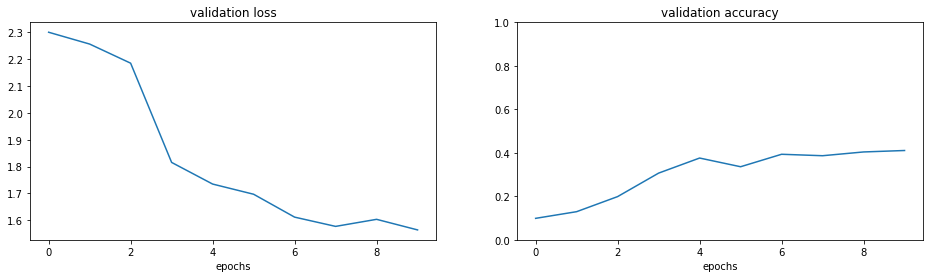

In [14]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(121)
ax.plot(history.history["val_loss"])
ax.set_title("validation loss")
ax.set_xlabel("epochs")

ax2 = fig.add_subplot(122)
ax2.plot(history.history["val_acc"])
ax2.set_title("validation accuracy")
ax2.set_xlabel("epochs")
ax2.set_ylim(0, 1)

plt.show()

In [15]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

Test loss: 1.61587193839
Test accuracy: 0.388000000159


In [16]:
X_train.shape[1:]

(96, 96, 3)

In [17]:
# vgg = keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=X_train.shape[1:])
vgg = keras.applications.VGG16(weights='imagenet', include_top=False,input_shape=(X_train.shape[1:]))
# vgg = keras.applications.VGG16(weights='imagenet', include_top=False,input_shape=(96,96,3))
# vgg = keras.applications.VGG16(weights='imagenet', include_top=True)

vgg.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 96, 96, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 96, 96, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 96, 96, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 48, 48, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 48, 48, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 48, 48, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 24, 24, 128)       0         
__________

In [18]:
# make a reference to VGG's input layer
inp = vgg.input

# make a new softmax layer with num_classes neurons
flatten = Flatten()(vgg.layers[-2].output)
out = Dense(num_classes, activation='softmax')(flatten)


# connect our new layer to the second to last layer in VGG, and make a reference to it
# out = new_classification_layer(vgg.layers[-2].output)

# create a new network between inp and out
model_new = Model(inp, out)

# new_classification_layer = Dense(num_classes, activation='softmax')

# model_new = Model(model_intermediate , new_classification_layer)
# #Need to add Flatten before Dense

# model_new.add(Dense(num_classes))
model_new.summary()
# model_new.save??



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 96, 96, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 96, 96, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 96, 96, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 48, 48, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 48, 48, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 48, 48, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 24, 24, 128)       0         
__________

In [19]:
# make all layers untrainable by freezing weights (except for last layer)
for l, layer in enumerate(model_new.layers[:-1]):
    layer.trainable = False

# ensure the last layer is trainable/not frozen
for l, layer in enumerate(model_new.layers[-1:]):
    layer.trainable = True

model_new.compile(loss='categorical_crossentropy',
              optimizer='adadelta',
              metrics=['accuracy'])
model_new.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 96, 96, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 96, 96, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 96, 96, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 48, 48, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 48, 48, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 48, 48, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 24, 24, 128)       0         
__________

In [20]:
#Do the actual stuff on VGG16 now
# num_of_epochs = 10
# latest_weights_filename = None
# for epoch in range(num_of_epochs):
#     print("Running Epoch %d" %epoch)
#     model_new.fit(X_train, y_train,
#              batch_size=64,
#              epochs=1,
#              validation_data=(X_val, y_val))
#     latest_weights_filename = 'ft_vgg16%d.h5' % epoch
#     model_new.save_weights(latest_weights_filename)

history2 = model_new.fit(X_train, y_train, 
                         batch_size=64, 
                         epochs=10, 
                         validation_data=(X_val, y_val))

Train on 3500 samples, validate on 750 samples
Epoch 1/10
3500/3500 [==============================] - 479s - loss: 1.3311 - acc: 0.5506 - val_loss: 0.9965 - val_acc: 0.6680
Epoch 2/10
3500/3500 [==============================] - 477s - loss: 0.7936 - acc: 0.7443 - val_loss: 0.8492 - val_acc: 0.7053
Epoch 3/10
3500/3500 [==============================] - 479s - loss: 0.6402 - acc: 0.7934 - val_loss: 0.7836 - val_acc: 0.7320
Epoch 4/10
3500/3500 [==============================] - 481s - loss: 0.5423 - acc: 0.8320 - val_loss: 0.7477 - val_acc: 0.7427
Epoch 5/10
3500/3500 [==============================] - 480s - loss: 0.4837 - acc: 0.8477 - val_loss: 0.7400 - val_acc: 0.7427
Epoch 6/10
3500/3500 [==============================] - 479s - loss: 0.4202 - acc: 0.8777 - val_loss: 0.7227 - val_acc: 0.7467
Epoch 7/10
3500/3500 [==============================] - 480s - loss: 0.3768 - acc: 0.8989 - val_loss: 0.7195 - val_acc: 0.7507
Epoch 8/10
3500/3500 [==============================] - 479s - l

In [21]:
print(keras.__version__)

2.0.8


In [22]:
!python --version

Python 3.6.3 :: Anaconda custom (64-bit)


In [23]:
loss, accuracy = model_new.evaluate(X_test, y_test, verbose=1)

print('Test loss:', loss)
print('Test accuracy:', accuracy)

750/750 [==============================] - 87s    
Test loss: 0.704158426762
Test accuracy: 0.746666666826
